In [2]:
import torch
import sys, os
sys.path.append('../')
import matplotlib.pyplot as plt
import seaborn as sns

import json
import pandas as pd
import numpy as np
import glob

## Task 1: maligant classifcation 
- FFDM: Linear classifier / locality-attention + linear classfier 
- US: MIL-attention + linear classfier 

In [44]:
sns.set_context("talk")
sns.set_style("whitegrid")
def plot_auc_learning_curve(logs, text):

    plt.figure(figsize=(8, 5))
    logs[logs['mode']=='val']['head4_auc'].plot(marker='o', use_index=False, alpha=0.6)

    highest = logs[logs['mode']=='val']['head4_auc'].max()
    epoch = logs[logs['mode']=='val']['head4_auc'].argmax()

    plt.scatter(y=highest, x=epoch, marker='*', color='r', s=300)
    plt.text(y=highest-0.001, x=epoch-1, text=f'highest AUC={highest:1.3f}', s=100)

    plt.ylabel('Test AUC '+text)
    plt.xlabel('epoch')
    plt.plot()

In [4]:
save_path = '/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/'

In [5]:
def get_lastest_runlogs(save_path, run_path):
    """gather the log of the lastest run and return log as data frame."""
    try:
        file = sorted(glob.glob(os.path.join(save_path, run_path, '*.json')))[-1]
        with open(file) as f:
            lines = f.readlines()[1:]
        logs = pd.DataFrame([json.loads(line) for line in lines])
    except:
        print(save_path, run_path)
        raise FileNotFoundError

    return logs

def get_comparison_table(modal_cls, model_path, exp_prefix, weight_init):
    performance = []
    for modal in modal_cls:
        for path in model_path:
            for exp in exp_prefix:
                for winit in weight_init:
                    try:
                        logs = get_lastest_runlogs(save_path, f'{modal}/{path}/{exp}{winit}')
                    
                        loss, auc = logs[logs['mode']=='val'].head4_loss.min(), logs[logs['mode']=='val'].head4_auc.max()

                        performance.append({'modal': modal, 'pretrain-exp': path,
                            'exp': exp, 
                            'weight init': winit.split('_')[-1] if winit!='' else 'cross-modal swav', 
                            'loss': loss, 'auc': auc})
                    except FileNotFoundError:
                        pass

    return pd.DataFrame(performance)



### FFDM:

#### Ablation study on the classifier complexity: Linear V.S. Linear +locality-attention

In [15]:
modal_cls = ['ffdm']
model_path = ['20220411_ffdm_latest.pth']
exp_prefix = ['balanced', 'locality_atten']
weight_init = ['', '_imagenet', '_randominit']

performance = get_comparison_table(modal_cls, model_path, exp_prefix, weight_init)
performance

,modal,pretrain-exp,exp,weight init,loss,auc
0,ffdm,20220411_ffdm_latest.pth,balanced,cross-modal swav,0.51060,0.57232
1,ffdm,20220411_ffdm_latest.pth,balanced,imagenet,0.51911,0.55301
2,ffdm,20220411_ffdm_latest.pth,balanced,randominit,0.54338,0.47133
3,ffdm,20220411_ffdm_latest.pth,locality_atten,cross-modal swav,0.51121,0.59027
4,ffdm,20220411_ffdm_latest.pth,locality_atten,imagenet,0.51882,0.56775
5,ffdm,20220411_ffdm_latest.pth,locality_atten,randominit,0.51670,0.46325


(0.4, 0.65)

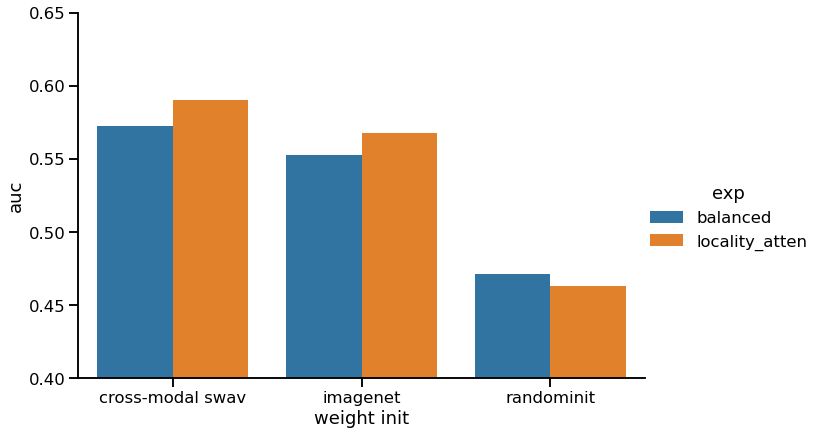

In [25]:
sns.set_context('talk')
sns.catplot(data=performance, y='auc', x='weight init', hue='exp', kind="bar", height=6, aspect=1.5)
plt.ylim(0.4, 0.65)

#### Ablantion study on the datasampler: fixed 4000 samples V.S. random negative samples per epoch

Basic configuration: Linear classifier +  locality-attention

In [52]:
modal_cls = ['ffdm', 'ffdm_fixed_datasampler', 'ffdm_biopsied_sampler']
model_path = ['20220411_ffdm_latest.pth']
exp_prefix = ['locality_atten']
weight_init = ['', '_imagenet', '_randominit']


performance = get_comparison_table(modal_cls, model_path, exp_prefix, weight_init)
performance

/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ ffdm_biopsied_sampler/20220411_ffdm_latest.pth/locality_atten_imagenet
/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ ffdm_biopsied_sampler/20220411_ffdm_latest.pth/locality_atten_randominit


,modal,pretrain-exp,exp,weight init,loss,auc
0,ffdm,20220411_ffdm_latest.pth,locality_atten,cross-modal swav,0.51121,0.59027
1,ffdm,20220411_ffdm_latest.pth,locality_atten,imagenet,0.51882,0.56775
2,ffdm,20220411_ffdm_latest.pth,locality_atten,randominit,0.51670,0.46325
3,ffdm_fixed_datasampler,20220411_ffdm_latest.pth,locality_atten,cross-modal swav,0.50497,0.57900
4,ffdm_fixed_datasampler,20220411_ffdm_latest.pth,locality_atten,imagenet,0.50243,0.57807
5,ffdm_fixed_datasampler,20220411_ffdm_latest.pth,locality_atten,randominit,0.51483,0.46700
6,ffdm_biopsied_sampler,20220411_ffdm_latest.pth,locality_atten,cross-modal swav,0.68967,0.57154


#### Ablantion study on the FFDM resolution: 736x480 V.S. 1472x960

In [27]:
modal_cls = ['ffdm', 'ffdm_highresolution.py']
model_path = ['20220411_ffdm_latest.pth', 'ffdm_latest.pth']
exp_prefix = ['locality_atten']
weight_init = ['']



performance = get_comparison_table(modal_cls, model_path, exp_prefix, weight_init)
performance

/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ ffdm/ffdm_latest.pth/locality_atten
/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ ffdm_highresolution.py/20220411_ffdm_latest.pth/locality_atten


,modal,pretrain-exp,exp,weight init,loss,auc
0,ffdm,20220411_ffdm_latest.pth,locality_atten,cross-modal swav,0.51121,0.59027
1,ffdm_highresolution.py,ffdm_latest.pth,locality_atten,cross-modal swav,0.50453,0.58517


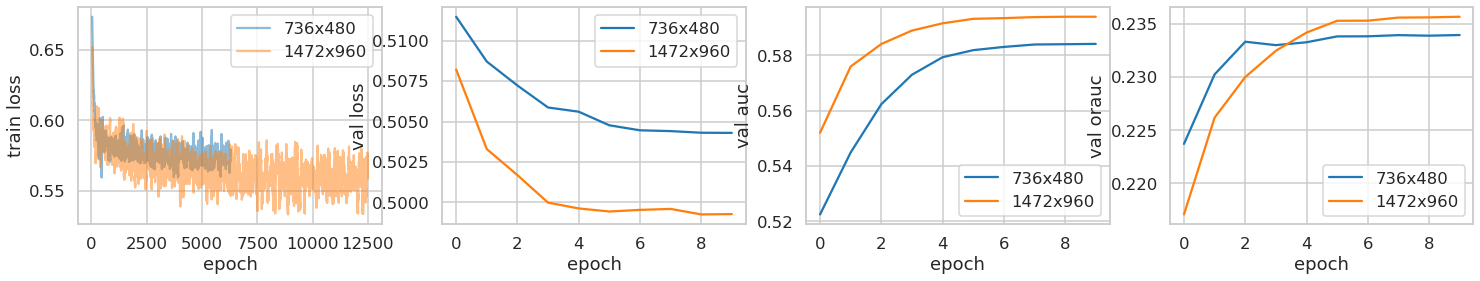

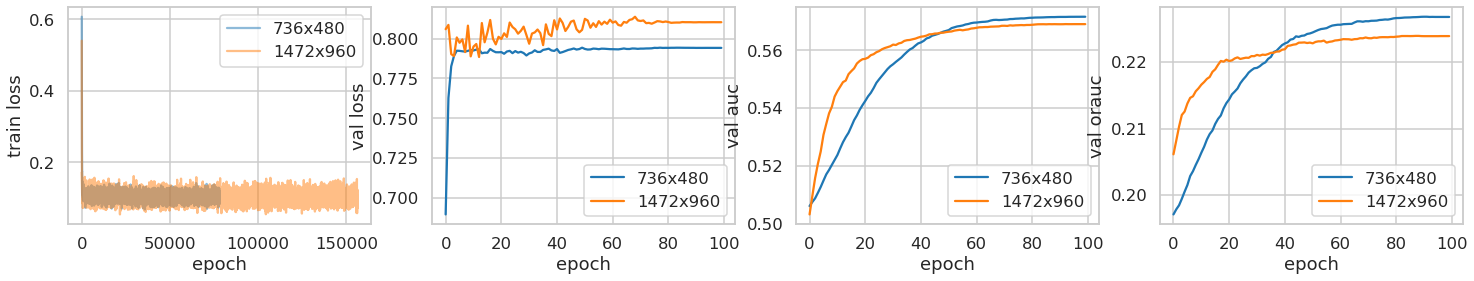

In [62]:
def learning_curves_comparsion(file_prefixes, titles): 
    fig, axs = plt.subplots(1, 4, figsize=(25, 4))
    for (modal, path, exp, winit), title  in zip(file_prefixes, titles):
        logs = get_lastest_runlogs(save_path, f'{modal}/{path}/{exp}{winit}')
        logs[logs['mode']=='train'].loss.rolling(50).mean().plot(
            use_index=False, label=title, ax=axs[0], alpha=0.5)

        axs[0].set_ylabel('train loss')
        axs[0].set_xlabel('epoch')
        axs[0].legend()

        logs[logs['mode']=='val'].head4_loss.plot(
            use_index=False, label=title, ax=axs[1])

        axs[1].set_ylabel('val loss')
        axs[1].set_xlabel('epoch')
        axs[1].legend()

        logs[logs['mode']=='val'].head4_auc.plot(
            use_index=False, label=title, ax=axs[2])

        axs[2].set_ylabel('val auc')
        axs[2].set_xlabel('epoch')
        axs[2].legend()
        if 'head4_prauc' in logs:

            logs[logs['mode']=='val'].head4_prauc.plot(
                use_index=False, label=title, ax=axs[3])

        axs[3].set_ylabel('val orauc')
        axs[3].set_xlabel('epoch')
        axs[3].legend()

    plt.show()


file_prefixes = [('ffdm', '20220411_ffdm_latest.pth', 'ablation_reso', ''), 
                 ('ffdm_highresolution', 'ffdm_latest.pth', 'ablation_reso', '')]
titles = ['736x480', '1472x960']
learning_curves_comparsion(file_prefixes, titles)



file_prefixes = [('ffdm_biopsied_sampler', '20220411_ffdm_latest.pth', 'locality_atten', ''),
                 ('ffdm_highresolution', 'ffdm_latest.pth', 'biopsied_sampler', '')]
titles = ['736x480','1472x960', '1472x960']
learning_curves_comparsion(file_prefixes, titles)

### Ultrasound

#### malignant prediction

In [58]:
modal_cls = ['us']
model_path = ['20220411_us_latest.pth']
exp_prefix = ['balanced', 'unfreeze_batch16']
weight_init = ['', '_imagenet', '_randominit', '_imagenet']

performance = get_comparison_table(modal_cls, model_path, exp_prefix, weight_init)
performance

,modal,pretrain-exp,exp,weight init,loss,auc
0,us,20220411_us_latest.pth,balanced,cross-modal swav,0.49529,0.71538
1,us,20220411_us_latest.pth,balanced,imagenet,0.54136,0.68299
2,us,20220411_us_latest.pth,balanced,randominit,0.51284,0.54318
3,us,20220411_us_latest.pth,balanced,imagenet,0.54136,0.68299
4,us,20220411_us_latest.pth,unfreeze_batch16,cross-modal swav,0.48989,0.73463
5,us,20220411_us_latest.pth,unfreeze_batch16,imagenet,0.53673,0.75103
6,us,20220411_us_latest.pth,unfreeze_batch16,randominit,0.50761,0.54767
7,us,20220411_us_latest.pth,unfreeze_batch16,imagenet,0.53673,0.75103


#### nosiy label prediction

In [73]:
def learning_curves_comparsion(file_prefixes, titles): 
    fig, axs = plt.subplots(1, 4, figsize=(25, 4))
    for (modal, path, exp, winit), title  in zip(file_prefixes, titles):
        logs = get_lastest_runlogs(save_path, f'{modal}/{path}/{exp}{winit}')
        logs[logs['mode']=='train'].loss.rolling(50).mean().plot(
            use_index=False, label=title, ax=axs[0], alpha=0.5)

        axs[0].set_ylabel('train loss')
        axs[0].set_xlabel('epoch')
        axs[0].legend()

        logs[logs['mode']=='val'].head4_loss.plot(
            use_index=False, label=title, ax=axs[1])

        axs[1].set_ylabel('val loss')
        axs[1].set_xlabel('epoch')
        axs[1].legend()

        logs[logs['mode']=='val'].head4_auc_micro.plot(
            use_index=False, label=title, ax=axs[2])

        axs[2].set_ylabel('val auc')
        axs[2].set_xlabel('epoch')
        axs[2].legend()
        if 'head4_prauc_micro' in logs:

            logs[logs['mode']=='val'].head4_prauc_micro.plot(
                use_index=False, label=title, ax=axs[3])

        axs[3].set_ylabel('val orauc')
        axs[3].set_xlabel('epoch')
        axs[3].legend()

    plt.show()

def get_comparison_table(modal_cls, model_path, exp_prefix, weight_init):
    performance = []
    for modal in modal_cls:
        for path in model_path:
            for exp in exp_prefix:
                for winit in weight_init:
                    try:
                        logs = get_lastest_runlogs(save_path, f'{modal}/{path}/{exp}{winit}')
                    
                        loss, auc, prauc = logs[logs['mode']=='val'].head4_loss.min(),\
                                logs[logs['mode']=='val'].head4_auc_micro.max(),\
                                logs[logs['mode']=='val'].head4_prauc_micro.max()        

                        performance.append({'modal': modal, 'pretrain-exp': path,
                            'exp': exp, 
                            'weight init': winit.split('_')[-1] if winit!='' else 'cross-modal swav', 
                            'loss': loss, 'auc': auc, 'prauc': prauc})
                    except FileNotFoundError:
                        pass

    return pd.DataFrame(performance)

In [74]:
modal_cls = ['us_noisy_token']
model_path = ['20220411_us_latest.pth']
exp_prefix = [ 'Adam1e2']
weight_init = ['', '_imagenet']

performance = get_comparison_table(modal_cls, model_path, exp_prefix, weight_init)
performance

,modal,pretrain-exp,exp,weight init,loss,auc,prauc
0,us_noisy_token,20220411_us_latest.pth,Adam1e2,cross-modal swav,0.01827,0.71862,0.04747
1,us_noisy_token,20220411_us_latest.pth,Adam1e2,imagenet,0.01995,0.67109,0.04470


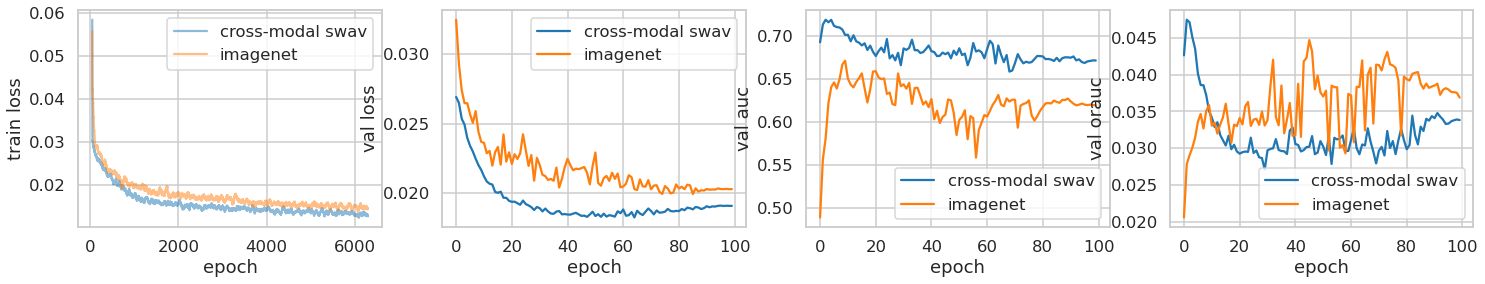

In [71]:

file_prefixes = [('us_noisy_token', '20220411_us_latest.pth', 'Adam1e2', ''),
                 ('us_noisy_token', '20220411_us_latest.pth', 'Adam1e2_imagenet', ''),]
titles = ['cross-modal swav', 'imagenet']
learning_curves_comparsion(file_prefixes, titles)